In [1]:
from dotenv import load_dotenv
import os, sys

sys.path.append(os.path.join(os.getcwd(), '..', '..'))

load_dotenv()

True

# Retriever Tool
- Chroma와 `BAAI/bge-m3` 이용

In [2]:
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

vectorstore = Chroma(
    persist_directory="./chatbot_20251108",
    embedding_function=HuggingFaceEmbeddings(model_name="BAAI/bge-m3"),
)
retriever = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 5}
)

c:\Users\Lee JinSeoung\OneDrive\Desktop\4학년 1학기\캡스톤디자인\chatbot-api\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Langchain prebuilt `create_retriever_tool` 이용하여 retriever tool 생성

In [3]:
from langchain_classic.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    name="retrieve_kongju_national_university_info",
    description="Search and return information about 국립공주대학교",
    retriever=retriever,
)

- retriever_tool 테스트

In [4]:
retriever_tool.invoke({"query": "소프트웨어학과 수강과목 알려줘"})

'[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 신호 및 시스템 과목은 3학점으로 3학년 1학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 웹프로그래밍 과목은 3학점(4시간 강의)으로 3학년 1학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 모바일프로그래밍 과목은 3학점(4시간 강의)으로 3학년 1학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 시스템분석설계 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 컴퓨터비전 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 컴퓨터그래픽스 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 클라우드컴퓨팅 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 IT실무영어 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 가상현실 과목은 3학점으로 4학년 1학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 분산컴퓨팅 과목은 3학점으로 4학년 2학기에 수강한다.\n\n[소프트웨어학과 교육과정표 2020년도 입학자 적용] 핵심교양 (3학점)인 선택 과목은

- LLM에 tool로 바인딩

In [5]:
from langchain_openai import ChatOpenAI

from src.agent.state import CustomState

model = ChatOpenAI(
    model="gpt-5-nano",
    temperature=0,
)

def generate_query_or_respond(state: CustomState):
    response = (
        model.bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [6]:
# 단순 응답 제공
input = {
    "messages": [
        {
            "role": "user",
            "content": "안녕하세요",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요? 국립공주대학교에 대해 알고 싶은 점이 있나요? 예를 들어 입학 안내, 학과 정보, 위치, 학비, 캠퍼스 생활 등 어떤 정보가 필요하신지 알려주시면 최신 정보를 찾아 드리겠습니다. 필요하시면 바로 검색해 드릴게요.


In [7]:
# semantic search 결과 제공

input_with_retrieval = {
    "messages": [
        {
            "role": "user",
            "content": "소프트웨어학과 4학년 수강과목 알려줘",
        }
    ]
}
generate_query_or_respond(input_with_retrieval)["messages"][-1].pretty_print()

================================== Ai Message ==================================

어떤 대학의 4학년 수강과목을 원하시는지 먼저 알려주시면 좋겠어요. 예를 들어 국립공주대학교의 소프트웨어학과를 말씀하시는지요, 아니면 다른 대학의 목록이 필요하신가요?

참고로 일반적으로 4학년(학사 과정의 마지막 해)에는 다음과 같은 구성의 과목이 많이 있습니다:
- 졸업설계/캡스톤 디자인: 팀 프로젝트 형태로 실제 소프트웨어 개발을 수행하고 보고서를 제출
- 소프트웨어 공학 심화 과목: 소프트웨어 아키텍처, 소프트웨어 테스트 및 품질보증, 소프트웨어 프로젝트 관리 등
- 알고리즘 및 이론 심화: 고급 알고리즘, 이산수학/계산이론 등
- 시스템/네트워크 및 운영체제 관련 심화: 분산 시스템, 클라우드 컴퓨팅, 운영체제 심화, 컴파일러
- 데이터베이스 및 데이터 엔지니어링: 데이터베이스 시스템, 빅데이터 처리, 데이터웨어하우징
- 인공지능/데이터 과학: 머신러닝, 인공지능 기초 및 응용, 데이터 마이닝
- 보안/시큐리티: 보안공학, 침해대응, 암호화 등
- 응용 분야 선택과목: 모바일 개발, 웹 개발, UI/UX, 드롭박스 등 분야별 심화 과목
- 현장실습/인턴십: 기업 연계 실습이나 프로젝트 기반 경험

원하신다면 특정 대학의 정확한 4학년 과목 목록을 공식 자료에서 찾아 정리해 드리겠습니다. 예를 들어 국립공주대학교를 원하신다면 바로 검색해서 최신 과목 표를 제공해 드릴게요. 진행해도 될까요?


# Document Relevancy Checker
- 검색된 문서가 질문과 연관되어 있는지 LLM 기반으로 판단

In [8]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
    "If score is 'no', show why it is not relevant in brief.\n"
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

def _get_last_message(messages):
    for m in reversed(messages):
        if getattr(m, "type", None) == "human" or getattr(m, "role", None) == "user":
            return m.content
    return ""

def grade_documents(
    state: CustomState
) -> Literal["generate", "rewrite_question"]:
    question = _get_last_message(state.get("messages"))
    context = state.get("documents")

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        model.with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )

    score = response.binary_score.strip().lower()
    return "generate" if score == "yes" else "rewrite_question"


# Human-in-the-loop
- 인간이 개입하여 작업을 명료화함

In [9]:
HITL_PROMPT = (
    "Answer the following sentence:\n\n"
    "제공하신 질문에 대한 답변을 드리기 위해 추가 정보가 필요합니다. 학과, 연도 등 세부 정보를 포함하여 질문을 구체적으로 작성해 주세요.\n\n"
    "Answer in {language}. If 'ko', use Korean. If 'en', use English."
    "Do not answer anything else."
)

def rewrite_question(state: CustomState):
    language = state.get("language", "ko")
    prompt = HITL_PROMPT.format(language=language)
    response = model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

# Build Graph
- 구현한 tool과 node를 이용하여 그래프 연결

2025-11-12 20:04:55 | INFO | graph.py: line 25 | Generating Node...
2025-11-12 20:04:55 | INFO | graph.py: line 33 | Node generation complete..!
2025-11-12 20:04:55 | INFO | graph.py: line 35 | Adding Edges...
2025-11-12 20:04:55 | INFO | graph.py: line 50 | Edges added successfully..!
2025-11-12 20:04:55 | INFO | graph.py: line 53 | Successfully compiled the state graph :D


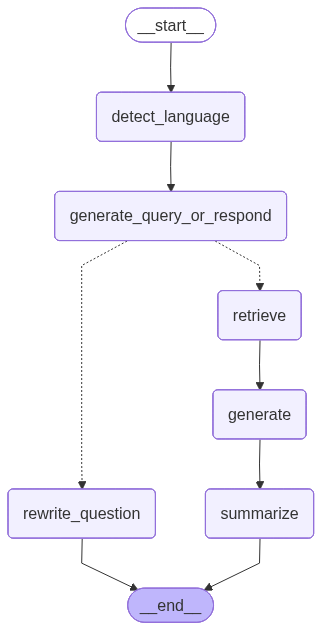

In [10]:
from src.agent.nodes import language_detection_node, generation_node, summarization_node
from src.agent.graph import visualize_graph, build_graph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver  

checkpointer = InMemorySaver()
# builder = StateGraph(CustomState)

# builder.add_node("detect_language", language_detection_node)
# builder.add_node(generate_query_or_respond)
# builder.add_node("retrieve", ToolNode([retriever_tool]))
# builder.add_node("rewrite_question", rewrite_question)
# builder.add_node("generate", generation_node)
# builder.add_node("summarize", summarization_node)

# builder.add_edge(START, "detect_language")
# builder.add_edge("detect_language", "generate_query_or_respond")
# builder.add_conditional_edges(
#     "generate_query_or_respond",
#     tools_condition,
#     {
#         "tools": "retrieve",
#         END: END,
#     }
# )
# builder.add_conditional_edges(
#     "retrieve",
#     grade_documents,
# )
# builder.add_edge("generate", "summarize")
# builder.add_edge("rewrite_question", END)
# builder.add_edge("summarize", END)

# graph = builder.compile(checkpointer=checkpointer)
graph = build_graph(checkpointer=checkpointer)
visualize_graph(graph)

- 그래프 실행

In [11]:
from langchain_core.runnables import RunnableConfig

config: RunnableConfig = {
    "configurable": {
        "thread_id": 123456
    }
}

def pretty_print_messages(config: RunnableConfig, query):
    for chunk in graph.stream(query, config=config):
        for node, output in chunk.items():
            print(f"Node: {node}")
            if "messages" in output and output["messages"]:
                output["messages"][-1].pretty_print()

In [12]:
query = {
    "messages": [
        {
            "role": "user",
            "content": "소프트웨어학과 4학년 수강과목 알려줘",
        }
    ]
}

pretty_print_messages(config=config, query=query)

Node: detect_language
Node: generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_kongju_national_university_info (call_BoUJU6irx4IV2lwfTAtEkbqA)
 Call ID: call_BoUJU6irx4IV2lwfTAtEkbqA
  Args:
    query: 공주대학교 소프트웨어학과 4학년 수강과목
Node: retrieve
================================= Tool Message =================================
Name: retrieve_kongju_national_university_info

수강신청은 강의나 실험·실습을 듣기 위해 자신이 이수할 교과목을 선택하여 신청하는 것이다.
5페이지
교육과정은 교양필수, 교양선택, 전공, 융합탐색 등으로 구성되어 있으며 각 항목의 학점과 비고는 다음과 같다. 교양필수의 기초교양필수는 10학점으로 공주대학교 학생들이 공통으로 이수해야 하는 교양과목이다. 교양선택에는 기초교양선택 14학점이 포함되며 이는 소프트웨어학과 학생들이 수강해야 하는 교양과목이고, 균형교양선택은 12학점으로 공과대학 학생들이 수강해야 하는 교양과목이다. 소양교양필수는 0학점으로 우리 학과 학생은 수강해서는 안 된다. 전공에서는 전공기초가 63학점으로 소프트웨어학과 학생들이 필수로 이수해야 하는 과목들이며, 전공핵심은 18학점 이상으로 소프트웨어학과 학생들이 수강해야 하는 전공과목이다. 융합탐색은 1~13학점 범위의 타학과 전공과목이다. 졸업학점 합계는 최소 130학점으로 졸업을 위한 기준이다.
6페이지
4. 수강신청하기
가. 수강신청 일정 안내  
자세한 내용은 공주대학교 홈페이지 정보광장 공지사항(https://www.kongju.ac.kr/bbs/

In [13]:
query_2 = {
    "messages": [
        {
            "role": "user",
            "content": "4학년 수강과목 알려줘",
        }
    ]
}

pretty_print_messages(config=config, query=query_2)

Node: detect_language
Node: generate_query_or_respond
================================== Ai Message ==================================

다음은 국립공주대학교 소프트웨어학과의 4학년 수강과목에 대한 정리입니다.

4학년 1학기
- 정보보안 과목 — 3학점
- 미래설계Ⅴ 과목 — 0학점

4학년 2학기
- 캡스톤디자인프로젝트Ⅱ — 3학점
- 미래설계Ⅵ 과목 — 0학점

추가로, 4학년 학과 커리큘럼은 오픈소스 커뮤니티로 사회 진출을 준비하는 단계로 운용되며, 실제 학습은 다음과 같은 오픈소스 도구/플랫폼 중심으로 이뤄집니다.
- 오픈소스 도구: Linux, Android
- 오픈소스 SW: Spring Framework, Kubernetes, NLTK, Luminoth
- 학습 방향: 협업과 프로젝트 관리에 중점

참고
- 위 내용은 2025~2029년 입학자 적용 교육과정표에 따른 일반 구성으로, 학기별 구체 과목명이나 학점은 수강신청 공지 및 학사일정에 따라 달라질 수 있습니다.
- 원하시면 본인의 학년, 이수현황에 맞춘 4학년 전체 연간 이수계획표를 만들어 드리겠습니다. 추가로 특정 과목이나 관심 영역이 있으면 알려 주세요.
Node: rewrite_question


TypeError: argument of type 'NoneType' is not iterable

In [ ]:
query_3 = {
    "messages": [
        {
            "role": "user",
            "content": "Hello, how are you?",
        }
    ]
}

pretty_print_messages(config=config, query=query_3)

Node: detect_language
Node: generate_query_or_respond
================================== Ai Message ==================================

Hi there! I’m here and ready to help. How can I assist you today?

If you’d like, I can:
- outline the 4th-year courses for the Software department at Kongju National University (course codes, credits, recommended enrollment timing)
- explain the curriculum structure (core vs. basic, electives, capstone)
- help you plan a 4-year or 2-year progression
- translate or summarize Korean documents you have

Let me know what you need or if you want to continue from where we left off with “24회.”
Node: rewrite_question
================================== Ai Message ==================================

We need additional information to answer your question. Please make your question more specific by including details such as the department and year.


In [ ]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='소프트웨어학과 4학년 수강과목 알려줘', additional_kwargs={}, response_metadata={}, id='c6f69b6f-5956-44d6-932f-9f5ef0589905'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jmMQ2LTwkW4fen61E6A1062e', 'function': {'arguments': '{"query":"국립공주대학교 소프트웨어학과 4학년 수강과목"}', 'name': 'retrieve_kongju_national_university_info'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 496, 'prompt_tokens': 160, 'total_tokens': 656, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 448, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-Cb2iIinqVtCG7wVU4KOp01QNmeBHF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--a7616065-1bf9-4821-aebd-25b84f8667ef-0', tool_calls=[{'name':

In [ ]:
# query_4 = {
#     "messages": [
#         {
#             "role": "user",
#             "content": "참여 기관은 어떻게 찾아서 신청할 수 있나요?",
#         }
#     ]
# }

# pretty_print_messages(config=config, query=query_4)